# Deep Learning Evaluation (Machine Learning TU Vienna 2018)

This notebook is used to evaluate Deep Learning for 2 different datasets:
    1. http://data.vicos.si/datasets/FIDS30/FIDS30.zip
    2. http://l2r.cs.uiuc.edu/~cogcomp/Data/Car/CarData.tar.gz
    
To run this notebook without the requirement of setting up all dependencies you can simply use following docker image:
https://cloud.docker.com/u/freecraver/repository/docker/freecraver/keras

Make sure to place this notebook in a shared folder and pass it as volume to the docker container at creation.
Example command (host path assuming Windows OS): `docker run -it -v //D//your//folder//here:/tf/notebooks -p 8888:8888 --name mlex_group8 freecraver/keras`

For GPU support you may substitute `freecraver/keras` with `tensorflow/tensorflow:latest-gpu-py3-jupyter` and install following modules manually via `pip install`:
* keras
* Pillow _(Image processing)_
* requests _(only if dataset not present)_

You still require an NVIDIA docker driver (https://github.com/NVIDIA/nvidia-docker). As the setup for such can be a cumbersome task, the default uses only CPU. Keep in mind that this leads to a major performance loss. (On a side note the tensorflow gpu image also has twice the size of the cpu one..)

Recommend Min. Resource Requirements (for Docker):
* 6 GB RAM

## Imports & Setup
Errors at this point indicate a problem with your environment :-)

In [1]:
import keras
import numpy as np

from PIL import Image

import requests
import zipfile
import tarfile
import io

import os
import glob

car_dir = 'res/car'
fruit_dir = 'res/fruit'

# create directories if they are not present already
if not os.path.exists(car_dir):
    os.makedirs(car_dir)
if not os.path.exists(fruit_dir):
    os.makedirs(fruit_dir)    

Using TensorFlow backend.


## Fetch datasets

This may take a while for the fruits dataset (450MB)

__NOTE: if you already have the data on your local machine simply copy it into the shared folder to sapre the time required for download. Use the following paths:__  
`res/car/` containing the extracted `CarData` folder  
`res/fruit/` containing the extracted `FIDS30` folder

In [2]:
fruit_url = 'http://data.vicos.si/datasets/FIDS30/FIDS30.zip'
car_url = 'http://l2r.cs.uiuc.edu/~cogcomp/Data/Car/CarData.tar.gz'

car_data_path = os.path.join(car_dir,'CarData')
fruits_data_path = os.path.join(fruit_dir, 'FIDS30')

if os.path.exists(car_data_path):
    print("Using local car data")
else:
    print("Fetching car data...")
    r = requests.get(car_url)
    t = tarfile.open(fileobj=io.BytesIO(r.content))
    t.extractall(path=car_dir)
    t.close()

if os.path.exists(fruits_data_path):
    print("Using local fruits data")
else:
    print("Fetching fruit data...")
    r = requests.get(fruit_url)
    z = zipfile.ZipFile(io.BytesIO(r.content))
    z.extractall(path=fruit_dir)

print("Finished fetching datasets")

Using local car data
Using local fruits data
Finished fetching datasets


## Retrieve images

**IMPORTANT NOTE: If your kernel crashes at this point, you may have to increase the amount of alllocated RAM for your docker container**

In [17]:
def get_car_images():
    files = glob.glob(os.path.join(car_data_path,'TrainImages', '*.pgm'))
    print("Found {} car files".format(len(files)))
    images = []
    image_names = []

    for filename in files:
        image_names.append(os.path.basename(filename))
        with Image.open(filename) as img:
            images.append(np.array(img))
    
    return np.array(images), image_names

def get_fruit_images():
    images = []
    image_names = []
    
    for dirpath, dirnames, filenames in os.walk(fruits_data_path):
        for filename in [f for f in filenames if f.endswith(".jpg")]:
            image_names.append(os.path.split(dirpath)[-1] + "_" + filename)
            print("Found {} fruit files".format(len(image_names)), end="\r")
            with Image.open(os.path.join(dirpath,filename)) as img:
                images.append(np.array(img))
    return np.array(images), image_names
        

car_images, car_img_names = get_car_images()
fruit_images, fruit_img_names = get_fruit_images() 

Found 1050 car files


## Check import images

acerolas_12.jpg


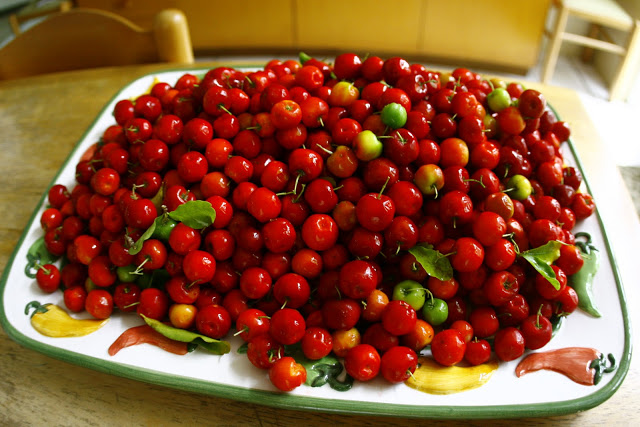

In [18]:
print(fruit_img_names[2])
Image.fromarray(fruit_images[2])

## Ground truth setup

While the goal of the car use case is to predict if a car is present or not (binary), the goal of the fruit dataset is to predict which out of $n$ fruits is present in a picture (n-ary)

In [30]:
cls_car = [0 if name.startswith('neg') else 1 for name in car_img_names]
cls_fruit = [name.split('_')[0] for name in fruit_img_names]

print("{} unique classes for cars".format(len(set(cls_car))))
print("{} unique classes for fruits".format(len(set(cls_fruit))))

2 unique classes for cars
30 unique classes for fruits


## Baseline values

Show how good a dumb classifier that always predicts the most common class is

In [35]:
def print_baseline_stats(cls):
    max_cnt = 0
    for v in set(cls):
        max_cnt = max(max_cnt, cls.count(v))
        print("Class {}: {}".format(v, cls.count(v)))

    print("Baseline accuracy: {}".format(max_cnt/len(cls)))
    
print("-"*20, "\nCar Baseline")
print_baseline_stats(cls_car)

print("-"*20, "\nFruits Baseline")
print_baseline_stats(cls_fruit)

-------------------- 
Car Baseline
Class 0: 500
Class 1: 550
Baseline accuracy: 0.5238095238095238
-------------------- 
Fruits Baseline
Class raspberries: 39
Class bananas: 42
Class oranges: 35
Class apricots: 30
Class blackberries: 37
Class mangos: 34
Class lemons: 29
Class olives: 23
Class cherries: 33
Class watermelons: 31
Class avocados: 26
Class grapefruits: 31
Class peaches: 27
Class plums: 31
Class strawberries: 46
Class grapes: 38
Class figs: 26
Class acerolas: 24
Class kiwifruit: 36
Class apples: 38
Class pineapples: 34
Class limes: 29
Class guava: 33
Class coconuts: 26
Class blueberries: 32
Class pomegranates: 30
Class tomatoes: 46
Class cantaloupes: 31
Class pears: 32
Class passionfruit: 22
Baseline accuracy: 0.04737384140061792
